In [168]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


import warnings
warnings.filterwarnings("ignore")

In [169]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
        ) # 

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
        ) # 

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
        ) # 

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
        ) #

        self.pool2 = nn.MaxPool2d(2, 2) #
        self.convblock100 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) #

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # 

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
        ) # 

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
        ) # 

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.pool2(x)
        x = self.convblock100(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [170]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
            Conv2d-3            [-1, 8, 28, 28]             576
              ReLU-4            [-1, 8, 28, 28]               0
         MaxPool2d-5            [-1, 8, 14, 14]               0
            Conv2d-6           [-1, 16, 14, 14]           1,152
              ReLU-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 16, 14, 14]           2,304
              ReLU-9           [-1, 16, 14, 14]               0
        MaxPool2d-10             [-1, 16, 7, 7]               0
           Conv2d-11              [-1, 8, 7, 7]             128
           Conv2d-12             [-1, 16, 5, 5]           1,152
             ReLU-13             [-1, 16, 5, 5]               0
           Conv2d-14             [-1, 1

In [171]:


torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [172]:
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph):
    model.train()
    train_loss = 0
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_loss /= len(train_loader.dataset)
    accuracy = 100. * correct / len(train_loader.dataset)
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        train_loss, correct, len(train_loader.dataset), accuracy
        ))
    
    train_loss_graph.append(train_loss)
    train_accuracy_graph.append(accuracy)
    return train_loss_graph, train_accuracy_graph, accuracy

incorrect_examples = []
def test(model, device, test_loader, test_loss_graph, test_accuracy_graph):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy
        ))
    test_loss_graph.append(test_loss)
    test_accuracy_graph.append(accuracy)
    return test_loss_graph, test_accuracy_graph


epoch number  1
Train set: Average loss: 0.0101, Accuracy: 34023/60000 (56.70%)
Test set: Average loss: 0.1475, Accuracy: 9530/10000 (95.30%)

epoch number  2
Train set: Average loss: 0.0009, Accuracy: 57816/60000 (96.36%)
Test set: Average loss: 0.0676, Accuracy: 9764/10000 (97.64%)

epoch number  3
Train set: Average loss: 0.0006, Accuracy: 58481/60000 (97.47%)
Test set: Average loss: 0.0622, Accuracy: 9806/10000 (98.06%)

epoch number  4
Train set: Average loss: 0.0005, Accuracy: 58782/60000 (97.97%)
Test set: Average loss: 0.0516, Accuracy: 9839/10000 (98.39%)

epoch number  5
Train set: Average loss: 0.0004, Accuracy: 59012/60000 (98.35%)
Test set: Average loss: 0.0475, Accuracy: 9852/10000 (98.52%)

epoch number  6
Train set: Average loss: 0.0004, Accuracy: 59123/60000 (98.54%)
Test set: Average loss: 0.0447, Accuracy: 9851/10000 (98.51%)

epoch number  7
Train set: Average loss: 0.0003, Accuracy: 59174/60000 (98.62%)
Test set: Average loss: 0.0450, Accuracy: 9846/10000 (98.46%)


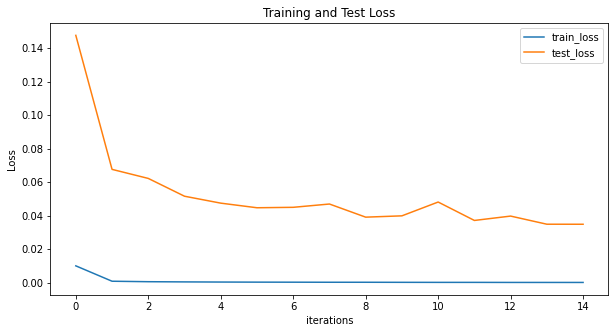

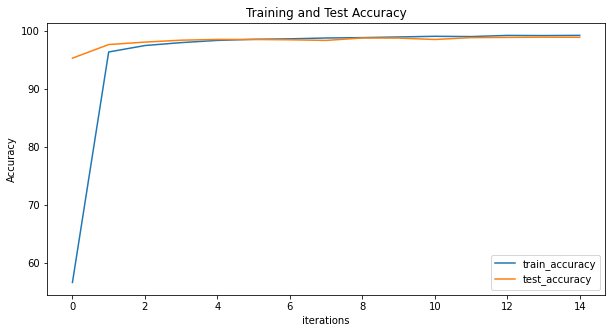

In [173]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_loss_graph = []
train_accuracy_graph = []
test_loss_graph = []
test_accuracy_graph = []
for epoch in range(1, 16):
    print('epoch number ', epoch)
    train_loss_graph, train_accuracy_graph, accuracy = train(model, device, train_loader, optimizer, epoch, train_loss_graph, train_accuracy_graph)
    test_loss_graph, test_accuracy_graph = test(model, device, test_loader, test_loss_graph, test_accuracy_graph)

import matplotlib.pyplot as plt

print(train_loss_graph, test_loss_graph)
print(train_accuracy_graph, test_accuracy_graph)
plt.figure(figsize=(10,5))
plt.title("Training and Test Loss")
plt.plot(train_loss_graph,label="train_loss")
plt.plot(test_loss_graph,label="test_loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.title("Training and Test Accuracy")
plt.plot(train_accuracy_graph,label="train_accuracy")
plt.plot(test_accuracy_graph,label="test_accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
